In [1]:
'''
감성분석의 경우 사전에 의존해 단순카운트 하는경우 
1. 한국어 감성사전의 미흡
2. 도메인특화 신조어 미적용
3. 순서에따른 긍/부정의 변화 미적용

따라서 순서정보를 학습하는 rnn 모델을 통해 라벨링 된 데이터를 학습해야함
1. 영화평 / 상품평.. 
2. 기학습된 임베딩은 어디에서추가?
3. 한국어는 자소를 분리한 fasttext가 더 효과적이다?
'''

'\n감성분석의 경우 사전에 의존해 단순카운트 하는경우 \n1. 한국어 감성사전의 미흡\n2. 도메인특화 신조어 미적용\n3. 순서에따른 긍/부정의 변화 미적용\n\n따라서 순서정보를 학습하는 rnn 모델을 통해 라벨링 된 데이터를 학습해야함\n1. 영화평 / 상품평.. \n2. 기학습된 임베딩은 어디에서추가?\n3. 한국어는 자소를 분리한 fasttext가 더 효과적이다?\n'

## import

In [2]:
import pandas as pd
import numpy as np
import re
from konlpy.tag import Okt
import matplotlib.pyplot as plt
%matplotlib inline
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [4]:
# 전처리 과정 여부
isTokenized = True

In [5]:
train_data = pd.read_table('./ratings_train.txt')
test_data = pd.read_table('./ratings_test.txt')

In [6]:
print(len(train_data),len(test_data))

150000 50000


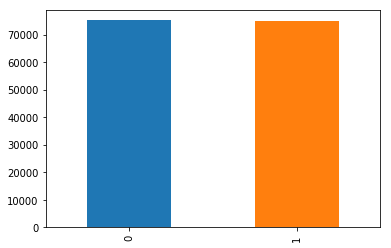

In [7]:
# 긍/부정 1:1비율로 150000 건
train_data['label'].value_counts().plot(kind='bar')

In [8]:
print(train_data.groupby('label').size().reset_index(name='count'))

   label  count
0      0  75173
1      1  74827


## preprocessing

### null 값 제거

In [9]:
print(train_data.isnull().values.any()) # null 확인
print(train_data.isnull().sum()) # null count
train_data.loc[train_data.document.isnull()]

True
id          0
document    5
label       0
dtype: int64


,id,document,label
25857,2172111,NaN,1
55737,6369843,NaN,1
110014,1034280,NaN,0
126782,5942978,NaN,0
140721,1034283,NaN,0


In [10]:
train_data = train_data.dropna(how='any') # null값 제거
print(train_data.isnull().values.any()) # null값 확인

False


In [11]:
test_data = test_data.dropna(how='any') # null값 제거
print(test_data.isnull().values.any()) # null값 확인

False


In [12]:
print(len(train_data), len(test_data)) # 제거후 count

149995 49997


### 특수문자, 이모지 제거, 형태소 분리

In [13]:
okt = Okt() # konlpy
stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']

# 특수문자, 이모지 제거
def cleanSentences(string):
    string = string.lower().replace("<br />"," ")
    string = re.sub(re.compile("[^0-9a-zA-Z가-힣 ]"), " ", string.lower())
    return string

# tokenizing
def getSentenceTokenized(sentence):
    tokenized = okt.morphs(sentence, stem=True) # 형태소 분리
    tokenized = [word for word in tokenized if not word in stopwords] # 불용어 제거
    return tokenized

# 
def getSentenceMatrix(sentence):
    pass

In [13]:
import pickle

if (isTokenized) :
    
    ## tokenize
    X_train = []
    for sentence in train_data['document']:    
        X_train.append(getSentenceTokenized(cleanSentences(sentence)))
    X_test = []
    for sentence in test_data['document']:
        X_test.append(getSentenceTokenized(cleanSentences(sentence)))
    
    ## tokenizing 된 파일 저장
    with open('./X_train_tokenized.pkl', 'wb') as f:
        pickle.dump(X_train, f)
    with open('./X_test_tokenized.pkl', 'wb') as f:
        pickle.dump(X_test, f)
        
else :
    with open('./X_train_tokenized.pkl', 'rb') as f:
        X_train = pickle.load(f)
    with open('./X_test_tokenized.pkl', 'rb') as f:
        X_test = pickle.load(f)
        

In [14]:
print(len(X_train), len(X_test))
print(X_train[:1], X_test[:1])

NameError: name 'X_train' is not defined

### 정수 인텍스 리스트 변환

In [15]:
maxWords = 30000
tokenizer = Tokenizer(num_words=maxWords) # 빈도높은 30000개의 단어만 선택하도록 tokenizer 객체생성
tokenizer.fit_on_texts(X_train) # test list로부터 단어 인덱스 사전구축

# 문자열을 정수 인덱스 리스트로 변환
X_train_seq = tokenizer.texts_to_sequences(X_train)
X_test_seq = tokenizer.texts_to_sequences(X_test)

In [16]:
print(X_train_seq[:4])

[[47, 457, 15, 258, 661], [901, 458, 42, 609, 1, 211, 1466, 23, 968, 679, 20], [374, 2467, 25999, 5115, 6387, 2, 219, 9], [6604, 105, 8272, 214, 56, 4, 25, 3660]]


최대길이 71
평균길이 10.77971265708857


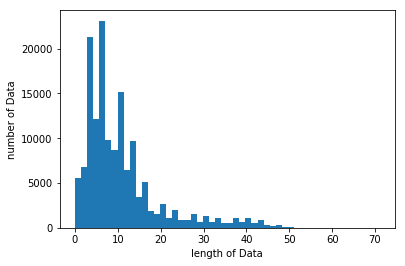

In [17]:
print('최대길이', max(len(l) for l in X_train))
print('평균길이', sum(map(len, X_train))/len(X_train))
plt.hist([len(s) for s in X_train], bins=50)
plt.xlabel('length of Data')
plt.ylabel('number of Data')
plt.show()

In [18]:
# 분포에 따라 전체 문장의 길이는 30으로 맞춘다.
max_len=30
X_train_seq = pad_sequences(X_train_seq, maxlen=max_len)
X_test_seq = pad_sequences(X_test_seq, maxlen=max_len)

In [19]:
# y값 
y_train=np.array(train_data['label'])
y_test=np.array(test_data['label'])

In [20]:
print(len(X_train_seq),len(X_test_seq), len(y_train), len(y_test))

149995 49997 149995 49997


## training data

In [21]:
'''
원-핫 인코딩을 통해 만들어진 벡터는 단어량에따라 고차원 희소(sparse) 벡터이기 때문에 낭비되는 연산이 많다
일반적으로 임베딩된 단어벡터를 사용하는것이 효율적

학습정확도를 올려보자
1. 초/중/종성 멀티레이어 임베딩
2. cnn+rnn concatenate 커스터마이즈
3. dropout(0.5)

'''

'\n원-핫 인코딩을 통해 만들어진 벡터는 단어량에따라 고차원 희소(sparse) 벡터이기 때문에 낭비되는 연산이 많다\n일반적으로 임베딩된 단어벡터를 사용하는것이 효율적\n\n학습정확도를 올려보자\n1. 초/중/종성 멀티레이어 임베딩\n2. cnn+rnn concatenate 커스터마이즈\n3. dropout(0.5)\n\n'

In [25]:
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Conv1D, MaxPooling1D
from tensorflow.keras.models import Sequential

In [41]:
# 학습조건...
model =Sequential()
model.add(Embedding(maxWords+1, 300)) # 임베딩 층


###### 커스터마이즈.. 이해
model.add(Dropout(0.5))
model.add(Conv1D(64, 5, padding='valid', activation='relu', strides=1))
# model.add(MaxPooling1D(pool_size=4)) # 최소길이의 문제인듯?

model.add(LSTM(128)) # rnn 층
model.add(Dense(1, activation='sigmoid')) # 출력
model.summary()
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_7 (Embedding)      (None, None, 300)         9000300   
_________________________________________________________________
dropout_5 (Dropout)          (None, None, 300)         0         
_________________________________________________________________
conv1d_5 (Conv1D)            (None, None, 64)          96064     
_________________________________________________________________
lstm_7 (LSTM)                (None, 128)               98816     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 129       
Total params: 9,195,309
Trainable params: 9,195,309
Non-trainable params: 0
_________________________________________________________________


In [42]:
history = model.fit(X_train_seq, y_train, epochs=5, batch_size=60, validation_split=0.2)

C:\Users\mediance_ssh\Anaconda3\lib\site-packages\tensorflow\python\ops\gradients_impl.py:108: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 119996 samples, validate on 29999 samples
Epoch 1/5
119996/119996 [==============================] - 275s 2ms/step - loss: 0.4874 - acc: 0.7494 - val_loss: 0.3783 - val_acc: 0.8383
Epoch 2/5
119996/119996 [==============================] - 272s 2ms/step - loss: 0.3683 - acc: 0.8365 - val_loss: 0.3529 - val_acc: 0.8484
Epoch 3/5
119996/119996 [==============================] - 272s 2ms/step - loss: 0.3336 - acc: 0.8556 - val_loss: 0.3420 - val_acc: 0.8525
Epoch 4/5
119996/119996 [==============================] - 270s 2ms/step - loss: 0.3107 - acc: 0.8684 - val_loss: 0.3533 - val_acc: 0.8459
Epoch 5/5
119996/119996 [==============================] - 274s 2ms/step - loss: 0.2930 - acc: 0.8764 - val_loss: 0.3385 - val_acc: 0.8567


In [43]:
print('\n 테스트 정확도: %.4f' % (model.evaluate(X_test_seq, y_test)[1]))

49997/49997 [==============================] - 29s 572us/step

 테스트 정확도: 0.8514


## test data

In [45]:
sents = ['굳 ㅋ',
         '최고!!!!!!!!!!!!!!!!',
         '보고싶은영화지만 별로라고 생각했다',
         '난 이영화가 이렇게까지 화재가 된 이유를 모르겠다',
         '음악이 주가 된, 최고의 음악영화',
         '발로만들어도 이거보단 잘만들겠네',
         '내가 뭘본거지',
         '배우들이 고생했네',
         '감독은 뭐했냐',
         '왓더퍽',
         '갓갓영화'
        ]
temp_test = []
for sent in sents : 
    temp_test.append(getSentenceTokenized(cleanSentences(sent)))

print(temp_test)


# sent = sent.replace("[^0-9a-zA-Z가-힣 ]"," ")
# sent = okt.morphs(sent, stem=True)
# stopwords=['의','가','이','은','들','는','좀','잘','걍','과','도','를','으로','자','에','와','한','하다']
# sent = [word for word in sent if not word in stopwords]
# sents.append(sent)
# print(sents)

temp_test = tokenizer.texts_to_sequences(temp_test)
# print(temp_test)
temp_test = pad_sequences(temp_test, maxlen=max_len)
# print(temp_test)

[['굳다'], ['최고'], ['보다', '영화', '지만', '별로', '라고', '생각'], ['난', '이영화', '이렇게', '까지', '화재', '되다', '이유', '모르다'], ['음악', '주가', '되다', '최고', '음악', '영화'], ['발', '로', '만들다', '거', '보단', '만들다'], ['내', '뭘', '본', '거지'], ['배우', '고생'], ['감독', '뭐'], ['왓더퍽'], ['갓', '갓', '영화']]


In [46]:
# 분류결과
results = model.predict(temp_test[:20])
for result in results:    
    np.set_printoptions(precision=2) # ndarray 자리수조정?
    if result > 0.5 :
        print("긍정 {0}%".format(result*100))
    else :
        print('부정 {0}%'.format((1-result)*100))

긍정 [95.51]%
긍정 [95.53]%
부정 [91.27]%
부정 [60.01]%
긍정 [98.26]%
부정 [95.68]%
부정 [93.38]%
부정 [85.55]%
부정 [92.31]%
긍정 [52.71]%
긍정 [67.02]%


In [53]:
test_data[:20]

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0
5,7898805,"음악이 주가 된, 최고의 음악영화",1
6,6315043,진정한 쓰레기,0
7,6097171,"마치 미국애니에서 튀어나온듯한 창의력없는 로봇디자인부터가,고개를 젖게한다",0
8,8932678,갈수록 개판되가는 중국영화 유치하고 내용없음 폼잡다 끝남 말도안되는 무기에 유치한c...,0
9,6242223,"이별의 아픔뒤에 찾아오는 새로운 인연의 기쁨 But, 모든 사람이 그렇지는 않네..",1
